<a href="https://colab.research.google.com/github/tomoi17/q-maqro-latter/blob/main/the_latter_half_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

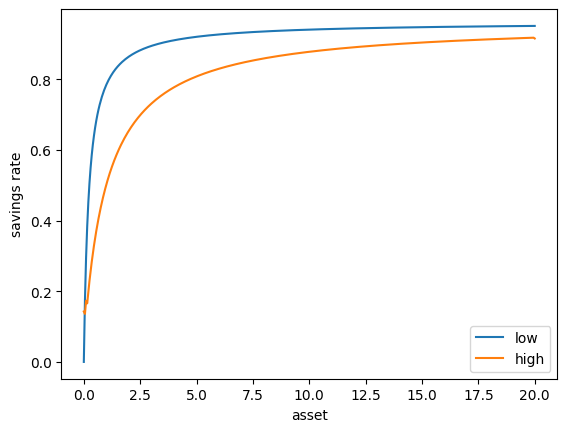

In [ ]:
import numpy as np
from scipy.stats import norm

def tauchen(n, mu, rho, sigma):

    # n: number of grid points
    # mu: mean of the AR(1) process
    # rho: AR(1) coeffient
    # sigma: standard deviatin of the error term

    m = 1 / np.sqrt(1 - rho**2)

    # compute the state space
    state_space = np.linspace(mu - m*sigma, mu + m*sigma, n)

    # compute the distance between grid points
    d = (state_space[n-1] - state_space[0]) / (n-1)

    # compute the transition probabilities
    transition_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if j==0:
                transition_matrix[i, 0] = norm.cdf((state_space[0] - rho*state_space[i] + d/2)/sigma)
            elif j==n-1:
                transition_matrix[i, n-1] = 1.0 - norm.cdf((state_space[n-1] - rho*state_space[i] - d/2)/sigma)
            else:
                transition_matrix[i, j] = norm.cdf((state_space[j] - rho*state_space[i] + d/2)/sigma) - norm.cdf((state_space[j] - rho*state_space[i] - d/2)/sigma)

    return transition_matrix, state_space

# function to compile parameters into one thing "param"
def setPar(
    sigma = 1.5, # risk aversion
    beta = 0.98, # subject discount factor
    rho = 0.6, # labor productivity persistence
    sigma_eps = 0.6, # labor productivity std
    a_l = 0, # lower bound of asset grids
    a_u = 20, # upper bound of asset grids
    NA = 401, # number of grids of a
    NH = 2, # number of grids of h
    mu_h = -0.7, # mean of log h
    alpha = 0.25,
    delta = 0.03,
    ):

    # # create a grid of asset holdings
    # a = np.linspace(a_l, a_u, NA)

    # making grids for ln h and solving for income transition probability using Tauchen's method
    pi, h = tauchen(NH, mu_h, rho, sigma_eps)
    h = np.exp(h)

    # create dictionary with parameters
    param = {}
    param['sigma'] = sigma
    param['beta'] = beta
    param['pi'] = pi
    param['h'] = h
    param['NA'] = NA
    param['NH'] = NH
    param['a_l'] = a_l
    param['a_u'] = a_u
    param['alpha'] = alpha
    param['delta'] = delta

    return param

def solve_household(param, r, w):
    # opening the box of param
    NA = param['NA']
    NH = param['NH']
    h = param['h']
    a_l = param['a_l']
    a_u = param['a_u']
    sigma = param['sigma']
    beta = param['beta']
    pi = param['pi']

    # create a grid of asset holdings
    a = np.linspace(a_l, a_u, NA)

    util = np.full((NA, NA, NH), -10000.0)
    # calculate utility if the agent chooses asset a[iap] for (a[ia]), h[ih])
    for ia in range(NA):
        for ih in range(NH):
            for iap in range(NA):
                cons = w*h[ih] + (1.0 + r)*a[ia] - a[iap]
                if cons > 0: # count only if consumption is positive
                    util[iap, ia, ih] = cons**(1.0-sigma)/(1.0-sigma)

    # Initialize some variables
    v = np.zeros((NA, NH))
    c = np.zeros((NA, NH))
    aplus = np.zeros((NA, NH))
    v_new = np.zeros((NA, NH))
    iaplus = np.full((NA, NH), -10000)

    # iterate on bellman's equation and get the decision rules and the value function
    tol = 1e-6
    test = 10.0
    reward = np.zeros((NA, NA, NH))

    while test > tol: # loop until value function converges
        for ia in range(NA):
            for ih in range(NH):
                reward[:, ia, ih] = util[:, ia, ih]
                for ihp in range(NH):
                    reward[:, ia, ih] += beta*pi[ih, ihp]*v[:, ihp]

                v_new[ia, ih] = np.max(reward[:, ia, ih])
                iaplus[ia, ih] = np.argmax(reward[:, ia, ih])

        test = np.max(abs(v_new - v))
        v = v_new

    # asset policy function
    aplus = a[iaplus]

    # consumption policy function
    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w*h[ih] + (1.0 + r)*a[ia] - aplus[ia, ih]

    return aplus, iaplus, c

def get_distribution(param, decisions):

    NA = param['NA']
    NH = param['NH']
    iaplus = decisions[1]
    pi = param['pi']

    test = 10 # initialize a test value to be greater than 1e-8
    phi = np.ones((NA, NH))/NA/NH # initialize the distribution phi to be uniform

    # loop until the test value is less than 1e-8
    while test > 1e-8:
        phi_new = np.zeros((NA, NH)) # initialize a new distribution phi_new to be all zero values
        for ia in range(NA):
            for ih in range(NH):
                for ihp in range(NH):
                    phi_new[iaplus[ia, ih], ihp] += pi[ih, ihp] * phi[ia, ih]

        test = np.max(np.abs(phi_new - phi)) # calculate the maximum difference
        phi = phi_new # update phi to be phi_new

    return phi

import matplotlib.pyplot as plt

# setting prices
r = 0.04 # interest rate
w = 1 # wage

param = setPar() # parameters
decisions = solve_household(param, r, w) # HH problem
aplus = decisions[0]
c = decisions[2]

# grids for figures
a_l = param['a_l']
a_u = param['a_u']
NA = param['NA']
a = np.linspace(a_l, a_u, NA)

# saving rate for low h
plt.plot(a, aplus[:, 0]/(c[:, 0] + aplus[:, 0]), label='low')
plt.xlabel("asset")
plt.ylabel("savings rate")

# saving rate for high h
plt.plot(a, aplus[:, 1]/(c[:, 1] + aplus[:, 1]), label='high')
plt.xlabel("asset")
plt.ylabel("savings rate")

plt.legend()

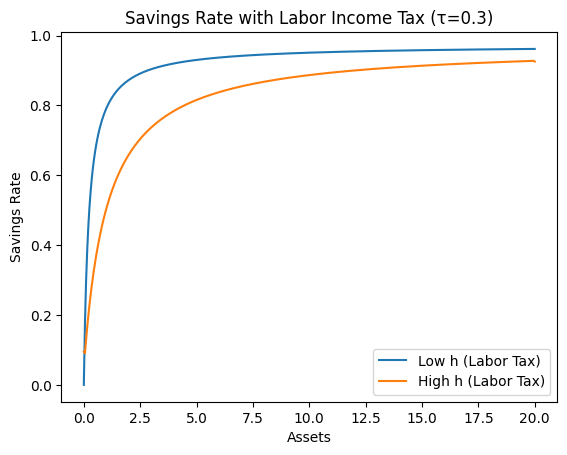

In [ ]:
# 労働所得税を導入するケース
def solve_household_with_labor_tax(param, r, w, tau_l):
    NA, NH, h, a_l, a_u, sigma, beta, pi = param['NA'], param['NH'], param['h'], param['a_l'], param['a_u'], param['sigma'], param['beta'], param['pi']
    a = np.linspace(a_l, a_u, NA)
    util = np.full((NA, NA, NH), -10000.0)
    for ia in range(NA):
        for ih in range(NH):
            for iap in range(NA):
                cons = (1 - tau_l) * w * h[ih] + (1.0 + r) * a[ia] - a[iap]
                if cons > 0:
                    util[iap, ia, ih] = cons**(1.0 - sigma) / (1.0 - sigma)
    v = np.zeros((NA, NH))
    c = np.zeros((NA, NH))
    aplus = np.zeros((NA, NH))
    v_new = np.zeros((NA, NH))
    iaplus = np.full((NA, NH), -10000)
    tol = 1e-6
    test = 10.0
    reward = np.zeros((NA, NA, NH))
    while test > tol:
        for ia in range(NA):
            for ih in range(NH):
                reward[:, ia, ih] = util[:, ia, ih]
                for ihp in range(NH):
                    reward[:, ia, ih] += beta * pi[ih, ihp] * v[:, ihp]
                v_new[ia, ih] = np.max(reward[:, ia, ih])
                iaplus[ia, ih] = np.argmax(reward[:, ia, ih])
        test = np.max(abs(v_new - v))
        v = v_new
    aplus = a[iaplus]
    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w * h[ih] + (1.0 + (1 - tau_l) * r) * a[ia] - aplus[ia, ih]

    return aplus, iaplus, c

# 労働所得税を導入して貯蓄率を計算
tau_l = 0.3
param_tax = setPar(beta=0.98)
decisions_tax = solve_household_with_labor_tax(param_tax, r, w, tau_l)
aplus_tax = decisions_tax[0]
c_tax = decisions_tax[2]

# グリッドの設定
a = np.linspace(param_tax['a_l'], param_tax['a_u'], param_tax['NA'])

# 貯蓄率をプロット
plt.figure()
plt.plot(a, aplus_tax[:, 0] / (c_tax[:, 0] + aplus_tax[:, 0]), label='Low h (Labor Tax)')
plt.plot(a, aplus_tax[:, 1] / (c_tax[:, 1] + aplus_tax[:, 1]), label='High h (Labor Tax)')
plt.xlabel("Assets")
plt.ylabel("Savings Rate")
plt.legend()
plt.title("Savings Rate with Labor Income Tax (τ=0.3)")
plt.show()

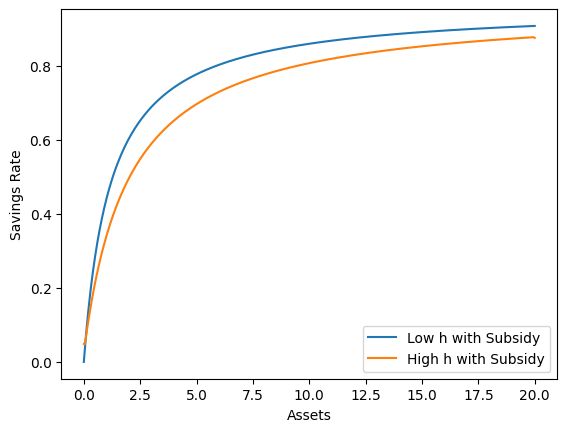

In [ ]:
def solve_household_with_subsidy(param, r, w, T):
    NA, NH, h, a_l, a_u, sigma, beta, pi = param['NA'], param['NH'], param['h'], param['a_l'], param['a_u'], param['sigma'], param['beta'], param['pi']
    a = np.linspace(a_l, a_u, NA)
    util = np.full((NA, NA, NH), -10000.0)
    for ia in range(NA):
        for ih in range(NH):
            for iap in range(NA):
                cons = w * h[ih] + (1.0 + r) * a[ia] + T - a[iap]
                if cons > 0:
                    util[iap, ia, ih] = cons**(1.0 - sigma) / (1.0 - sigma)
    v = np.zeros((NA, NH))
    c = np.zeros((NA, NH))
    aplus = np.zeros((NA, NH))
    v_new = np.zeros((NA, NH))
    iaplus = np.full((NA, NH), -10000)
    tol = 1e-6
    test = 10.0
    reward = np.zeros((NA, NA, NH))
    while test > tol:
        for ia in range(NA):
            for ih in range(NH):
                reward[:, ia, ih] = util[:, ia, ih]
                for ihp in range(NH):
                    reward[:, ia, ih] += beta * pi[ih, ihp] * v[:, ihp]
                v_new[ia, ih] = np.max(reward[:, ia, ih])
                iaplus[ia, ih] = np.argmax(reward[:, ia, ih])
        test = np.max(abs(v_new - v))
        v = v_new
    aplus = a[iaplus]
    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w * h[ih] + (1.0 + r) * a[ia] + T - aplus[ia, ih]
    return aplus, iaplus, c

# 一括補助金を考慮して貯蓄率を計算
T = 1
decisions_subsidy = solve_household_with_subsidy(param, r, w, T)
aplus_subsidy = decisions_subsidy[0]
c_subsidy = decisions_subsidy[2]

# 貯蓄率をプロット
plt.figure()
plt.plot(a, aplus_subsidy[:, 0] / (c_subsidy[:, 0] + aplus_subsidy[:, 0]), label='Low h with Subsidy')
plt.plot(a, aplus_subsidy[:, 1] / (c_subsidy[:, 1] + aplus_subsidy[:, 1]), label='High h with Subsidy')
plt.xlabel("Assets")
plt.ylabel("Savings Rate")
plt.legend()
plt.show()


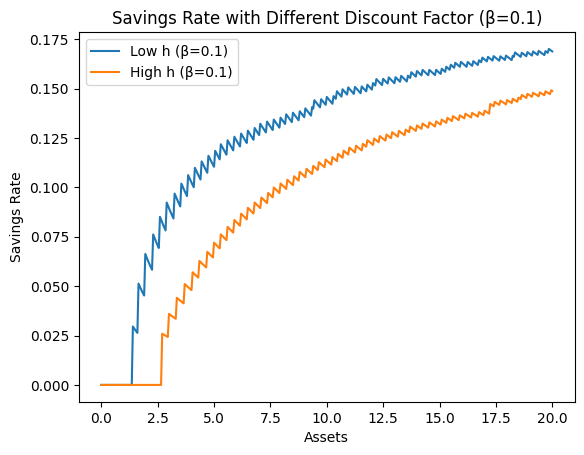

In [6]:
# 新しいパラメータ設定（β=0.1）
param_beta_0_1 = setPar(beta=0.1)

# 新しいパラメータで家計の最適化問題を解く
decisions_beta_0_1 = solve_household(param_beta_0_1, r, w)
aplus_beta_0_1 = decisions_beta_0_1[0]
c_beta_0_1 = decisions_beta_0_1[2]

# グリッドの設定
a = np.linspace(param_beta_0_1['a_l'], param_beta_0_1['a_u'], param_beta_0_1['NA'])

# 貯蓄率をプロット
plt.figure()
plt.plot(a, aplus_beta_0_1[:, 0] / (c_beta_0_1[:, 0] + aplus_beta_0_1[:, 0]), label='Low h (β=0.1)')
plt.plot(a, aplus_beta_0_1[:, 1] / (c_beta_0_1[:, 1] + aplus_beta_0_1[:, 1]), label='High h (β=0.1)')
plt.xlabel("Assets")
plt.ylabel("Savings Rate")
plt.legend()
plt.title("Savings Rate with Different Discount Factor (β=0.1)")
plt.show()
